# Collecting downloaded files and Save as a parquet file

In [12]:
import polars as pl
import os

        
def is_not_valid(f: str) -> bool:
    return not f.endswith('.csv') or '-' in f # or '.P,' not in f


def convert_k(val):
    if isinstance(val, str) and val.endswith('K'):
        return float(val[:-1]) * 1000
    return float(val)

folder = '../dumdum'
ohlcv = []

for f in os.listdir(folder):
    if is_not_valid(f):
        continue

    path = os.path.join(folder, f)
    try:
        df = pl.read_csv(
            path, 
            schema_overrides={c: pl.Float64 for c in ['open', 'high', 'low', 'close', 'Volume']},
            null_values=["∅"], ignore_errors=True
        )
    except Exception as e:
        print(f"❌ Skipping file {f} due to read error: {e}")
        continue
    if 'date' in df.columns: # ['date', 'time', 'open', 'high', 'low', 'close', 'vol']
        df = df.with_columns(
            (pl.col("date") + " " + pl.col("time")).str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M").alias("datetime")
        )
        df = df.with_columns(
            (pl.col("datetime").cast(pl.Int64) // 1_000_000_000)# nanoseconds → seconds
            .alias("time")
        )
        df = df.select(["time", "open", "high", "low", "close", pl.col("vol").alias("Volume")])
        if df.schema.get('Volume') == pl.String:
            df = df.with_columns(
                pl.col("Volume")
                .str.replace_all(r"([0-9.]+)K", r"${1}000")
                .str.replace_all(r"([0-9.]+)M", r"${1}000000")
                .str.strip_chars()
                .cast(pl.Float64)
                .alias("Volume")
            )
    if df.schema.get('time') != pl.Int64:
        continue

    df = df.with_columns([
        pl.lit(f.split('_')[-2].lower()).alias('Exchange'),
        pl.lit(f.split('_')[-1].split(',')[0]).alias('Pair')
    ])
    ohlcv.append(df)
print(f"✅ Processed {len(ohlcv)} files from {folder}")

# 병합 및 중복 제거
prev = pl.read_parquet('../tradingview_ohlcv.parquet').with_columns(
    (pl.col("time").cast(pl.Int64) // 1_000_000_000).alias("time")
)
print(f"✅ Loaded previous data with {prev.shape[0]} rows")
df_all = pl.concat(ohlcv, how="vertical").unique()
df_all = pl.concat([prev, df_all], how="vertical").unique()
df_all.write_parquet('../tradingview_ohlcv2.parquet')

✅ Processed 6680 files from ../dumdum
✅ Loaded previous data with 12613878 rows


# Kimchi Premium

In [13]:
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

df = pq.read_table('../tradingview_ohlcv2.parquet').drop_columns(['open', 'high', 'low',])
df = df.filter(pc.is_in(df['Exchange'], pa.array(['upbit', 'binance', 'bitfinex', 'coinbase', 'kraken', 'binanceus'])))

df

pyarrow.Table
time: int64
close: double
Volume: double
Exchange: large_string
Pair: large_string
----
time: [[1734011100,1727384400,1741995600,1731596400,1735340400,...,1599741900,1750489200,1729558800,1611100800,1746127800],[1671026400,1721088000,1708063200,1724940000,1669598400,...,1731000000,1678885200,1742255100,1742766300,1697677200],...,[1674691200,1729777200,1751181300,1733612400,1749295200,...,1737523800,1748260800,1745287200,1730408400,1744963200],[1687310100,1687046400,1735818000,1675627200,1691074800,...,1736725500,1747357200,1700236800,1675789200,1738071900]]
close: [[18.389,2641.5,83993.5,163.7,0.8747,...,0.2465,140.24,0.09538,42.5334,0.91235],[1335.373,0.8458,112.5,0.0079843,1164.75,...,2859.3,81.51,1926.26,6.638,0.05811],...,[23232.45,0.5303,0.5615,99929.32,3.2702,...,42.42,178.15,2.0927,2522.17,19.2],[0.0834,244.1,3475.4,22893.17,7.211,...,0.33578,104030,55.203,6.82,0.01942]]
Volume: [[4913.36,0.4265,0.27068921,78497.5,517670.04432591,...,9100.6,1771.81580163,8246414,30

In [14]:
import pandas as pd 

def price_diff(df, kor_exc, global_exc):

    glob = df.filter(pc.equal(df['Exchange'], global_exc)).drop_columns(['Exchange', 'Pair'])
    kor = df.filter(pc.equal(df['Exchange'], kor_exc)).drop_columns(['Exchange', 'Pair'])

    # merge by time using pyarrow
    df_merged = glob.join(kor, 'time', join_type='inner', left_suffix=f'_{global_exc}', right_suffix=f'_{kor_exc}').combine_chunks()
    print(df_merged.num_rows, 'rows after merge')

    # price: (binance - upbit) / upbit

    diff = pc.subtract(df_merged[f'close_{kor_exc}'], df_merged[f'close_{global_exc}'])
    price_diff = pc.divide(diff, df_merged[f'close_{kor_exc}'])

    df_merged = df_merged.append_column('price_error', price_diff).set_column(
        0,  # 첫 번째 컬럼 인덱스
        'time',
        pc.cast(df_merged['time'], pa.timestamp('s'))
    ).to_pandas().sort_values(by='time')
    df_merged.time = df_merged.time.dt.tz_localize('UTC').dt.tz_convert('Asia/Seoul')
    df_merged = df_merged.set_index('time').resample('5min').mean().reset_index().fillna(0)
    print(df_merged.duplicated(subset=['time']).shape[0], 'duplicated rows')
    return df_merged

In [15]:
kor_excs = ['upbit']
global_excs = ['binance', 'bitfinex', 'coinbase', 'binanceus', 'okx', 'bitget']

for i in range(2):
    for token in ['BTCUSDC', 'ETHUSDC', 'XRPUSDC', 'LTCUSDC', 'SOLUSDC', 'PEPEUSDC', 'DOGEUSDC', 'ADAUSDC', ]:
        if i == 0:
            token = token.replace('USDC', 'USDT')
        for kor_exc in kor_excs:
            for global_exc in global_excs:
                print(f"Processing {kor_exc} vs {global_exc}")
                df_result = price_diff( df.filter(pc.is_in(df['Pair'], pa.array([token]))), kor_exc, global_exc)
                if df_result.empty:
                    print(f"❌ No data for {token} with {kor_exc} vs {global_exc}")
                    continue
                df_result.to_csv(f'./kimchi-premium/{token}_{kor_exc}_{global_exc}_price_diff.csv', index=False)
                print(f"✅ Saved {token}_{kor_exc}_{global_exc}_price_diff.csv with {df_result.shape[0]} rows")

Processing upbit vs binance
82697 rows after merge
262249 duplicated rows
✅ Saved BTCUSDT_upbit_binance_price_diff.csv with 262249 rows
Processing upbit vs bitfinex
0 rows after merge
0 duplicated rows
❌ No data for BTCUSDT with upbit vs bitfinex
Processing upbit vs coinbase
62953 rows after merge
262249 duplicated rows
✅ Saved BTCUSDT_upbit_coinbase_price_diff.csv with 262249 rows
Processing upbit vs binanceus
62485 rows after merge
262249 duplicated rows
✅ Saved BTCUSDT_upbit_binanceus_price_diff.csv with 262249 rows
Processing upbit vs okx
0 rows after merge
0 duplicated rows
❌ No data for BTCUSDT with upbit vs okx
Processing upbit vs bitget
0 rows after merge
0 duplicated rows
❌ No data for BTCUSDT with upbit vs bitget
Processing upbit vs binance
40590 rows after merge
472501 duplicated rows
✅ Saved ETHUSDT_upbit_binance_price_diff.csv with 472501 rows
Processing upbit vs bitfinex
0 rows after merge
0 duplicated rows
❌ No data for ETHUSDT with upbit vs bitfinex
Processing upbit vs 

Visualizing BTCUSDT - upbit vs binance


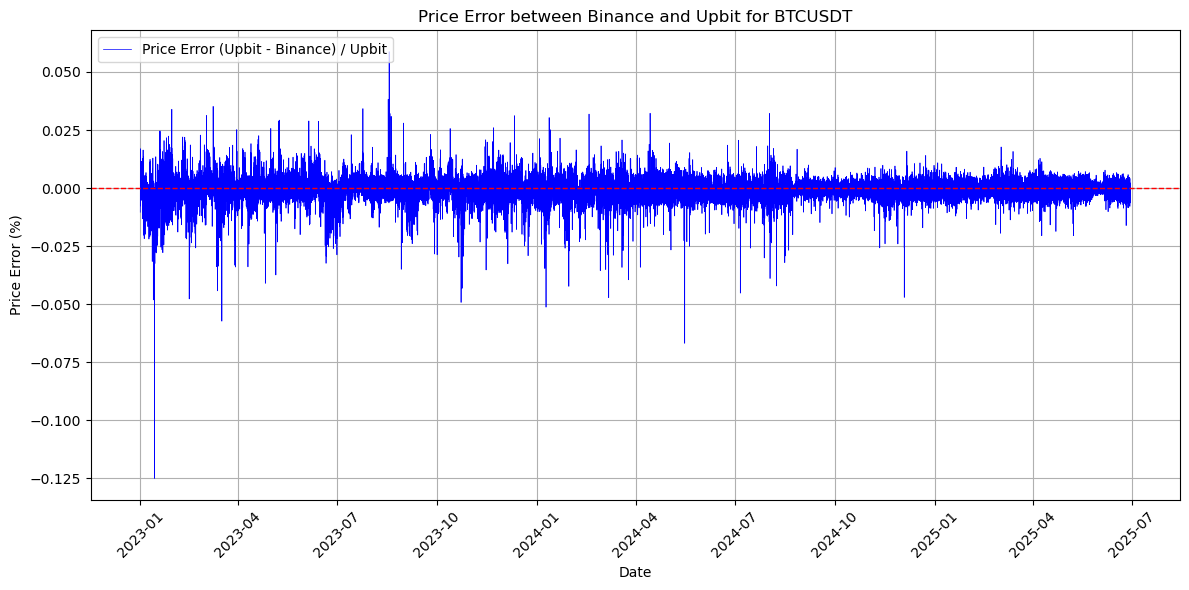

Visualizing BTCUSDT - upbit vs coinbase


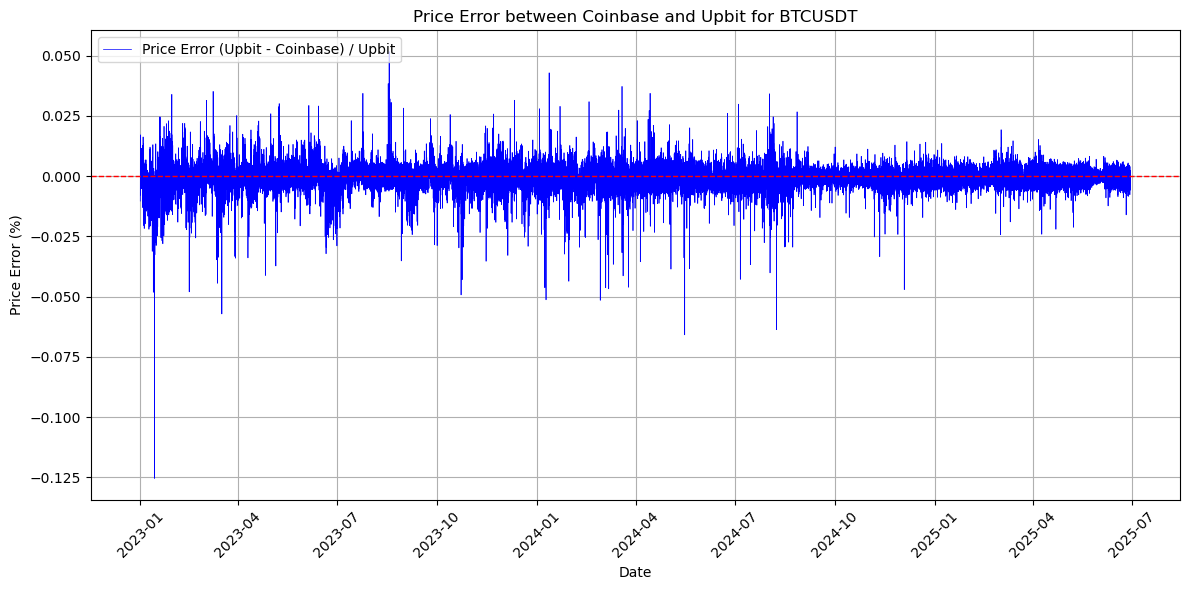

Visualizing BTCUSDT - upbit vs binanceus


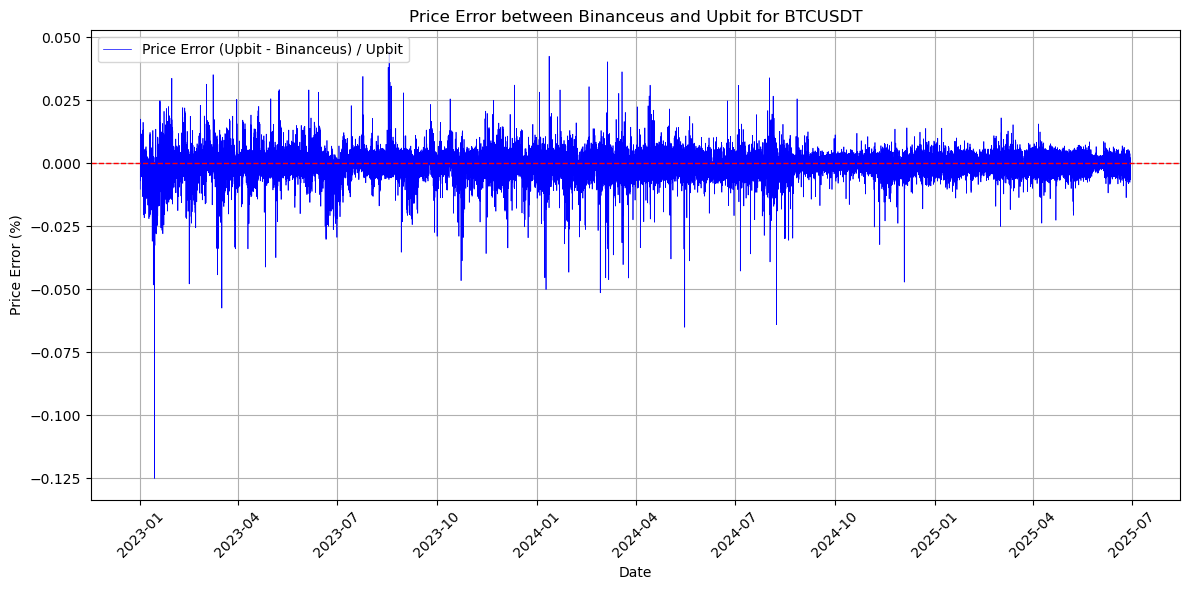

Visualizing ETHUSDT - upbit vs binance


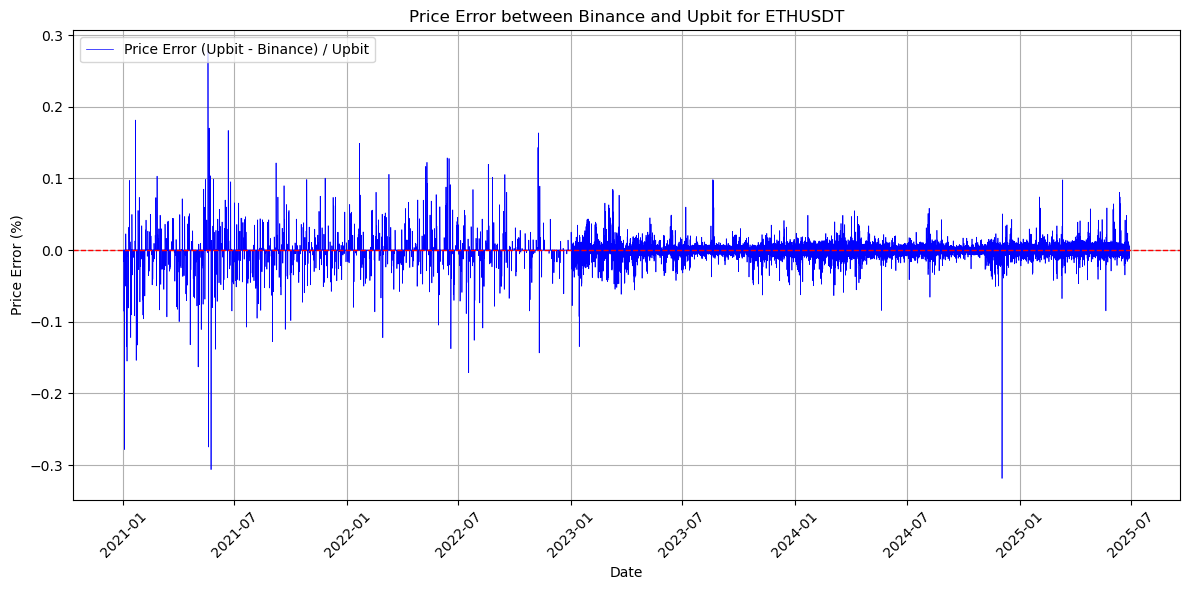

Visualizing ETHUSDT - upbit vs coinbase


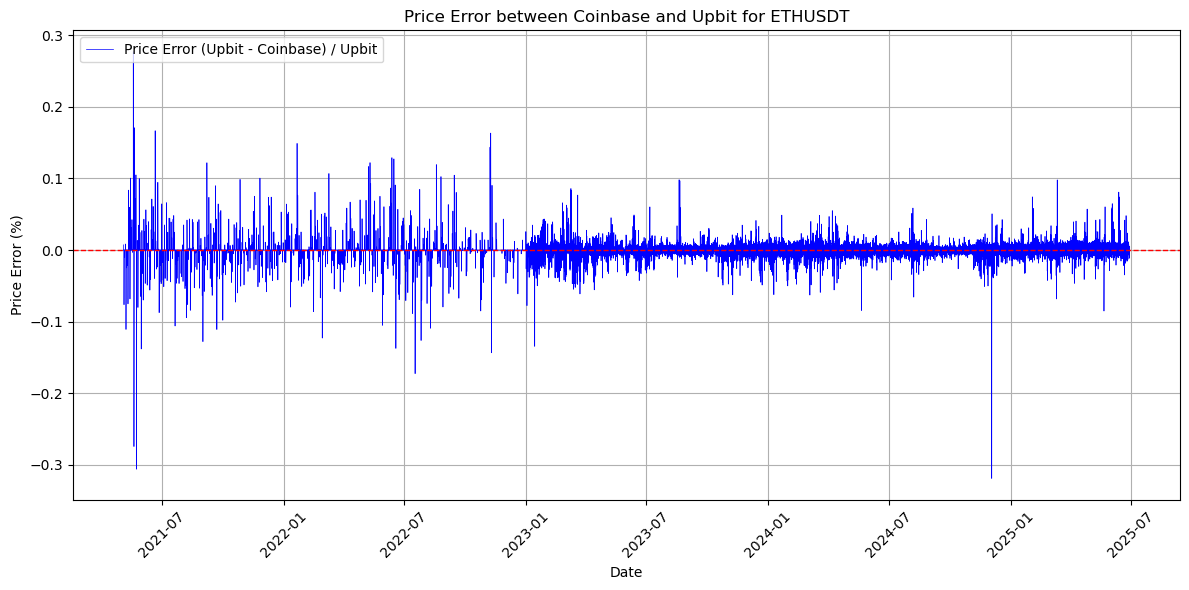

Visualizing ETHUSDT - upbit vs binanceus


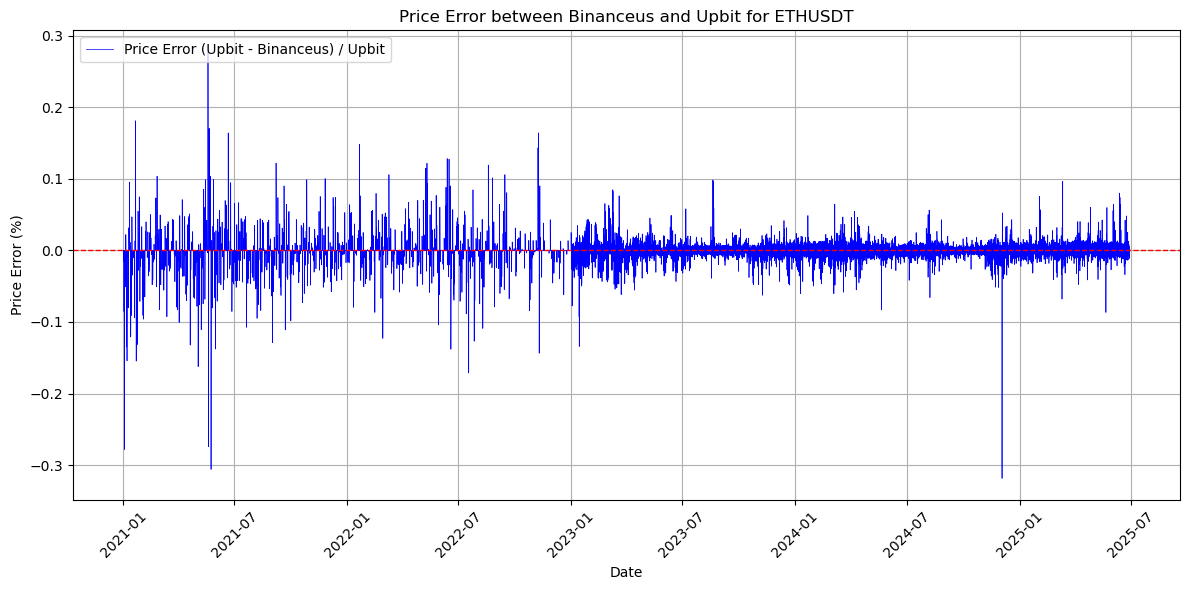

Visualizing XRPUSDT - upbit vs binance


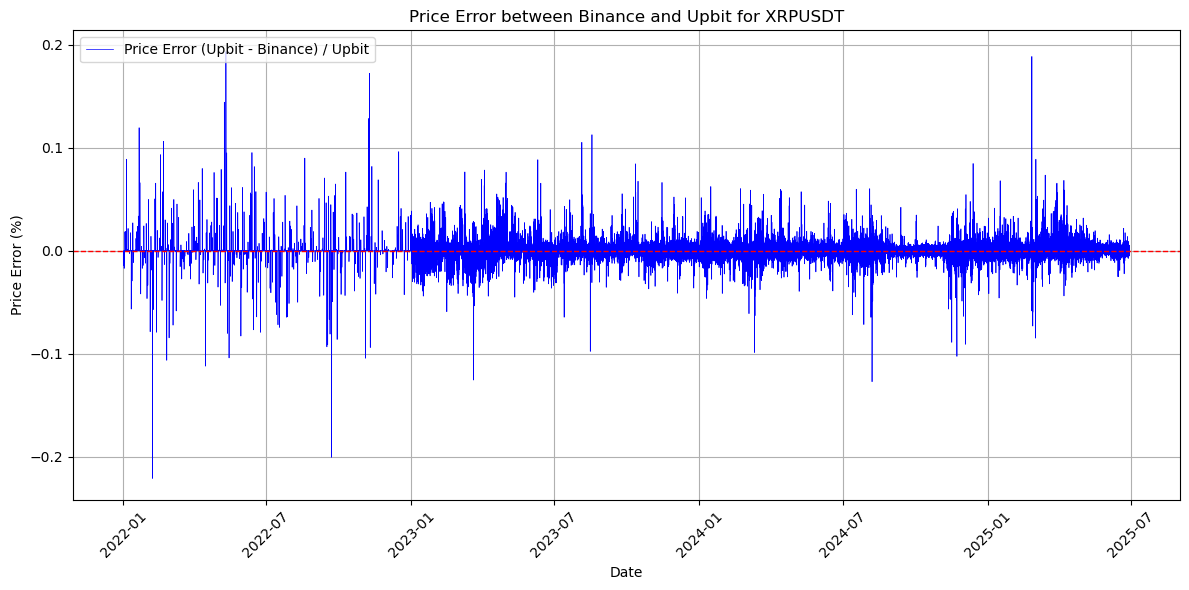

Visualizing XRPUSDT - upbit vs coinbase


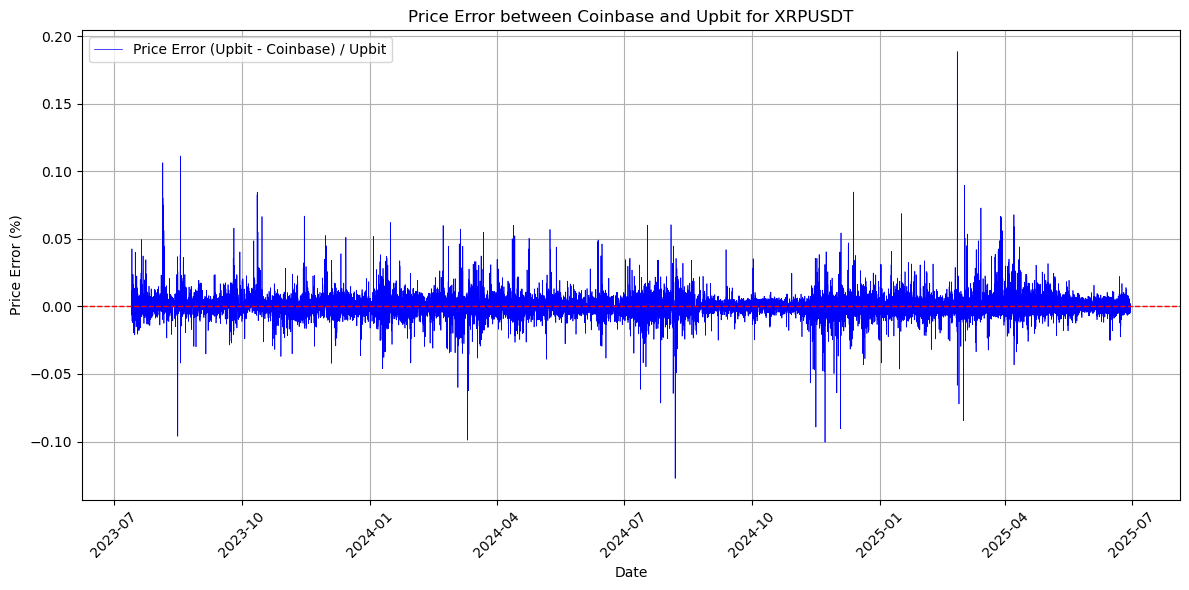

Visualizing XRPUSDT - upbit vs binanceus


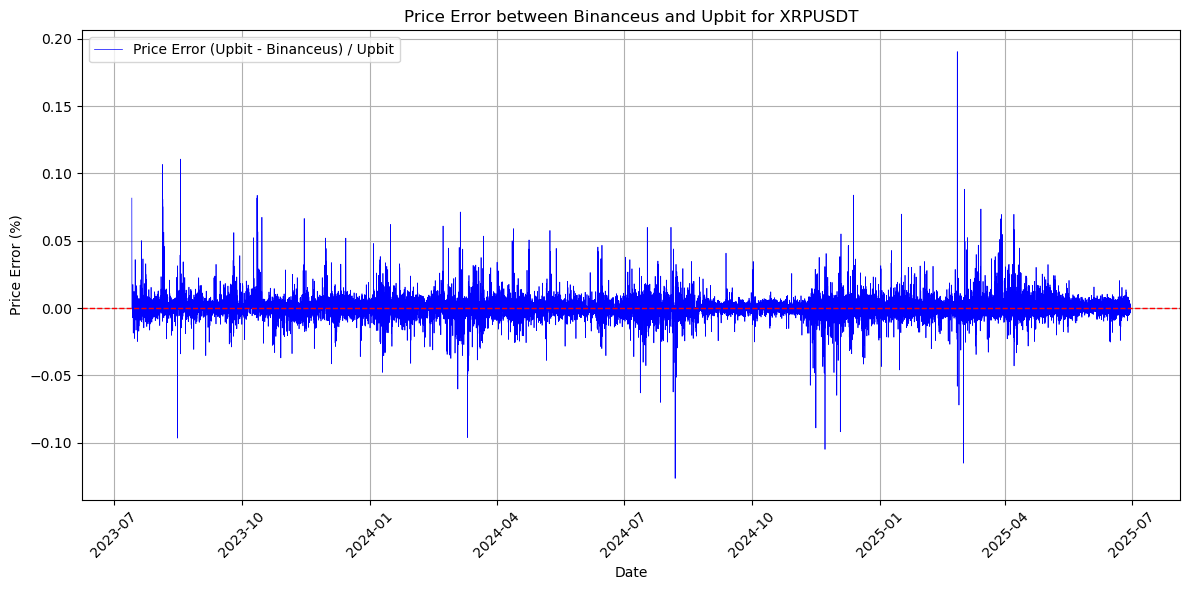

Visualizing SOLUSDT - upbit vs binance


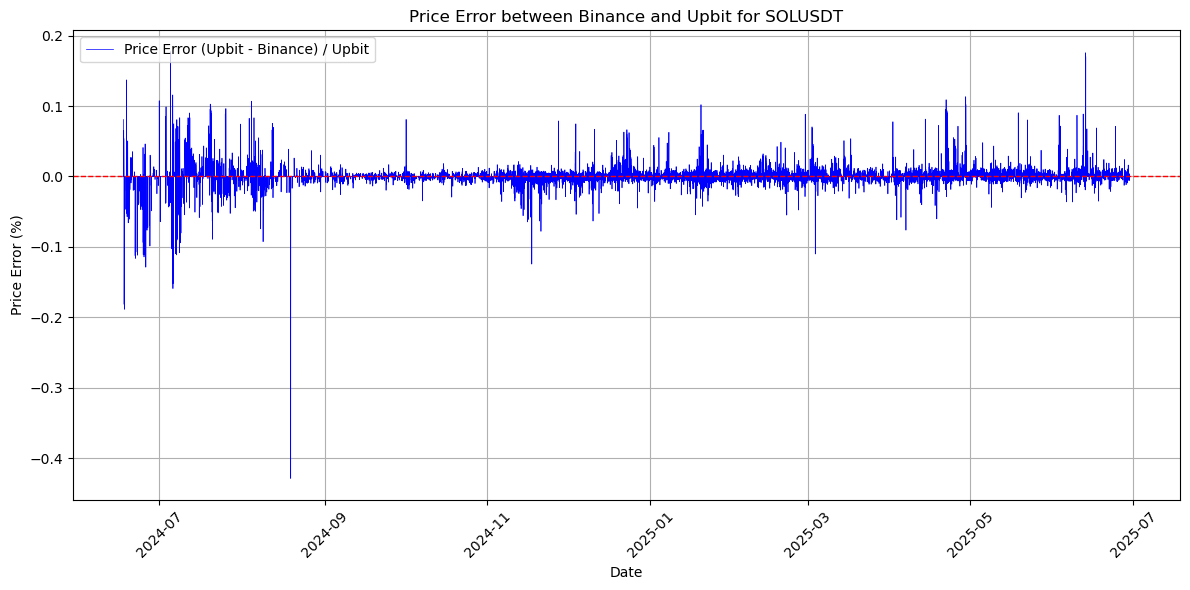

Visualizing SOLUSDT - upbit vs coinbase


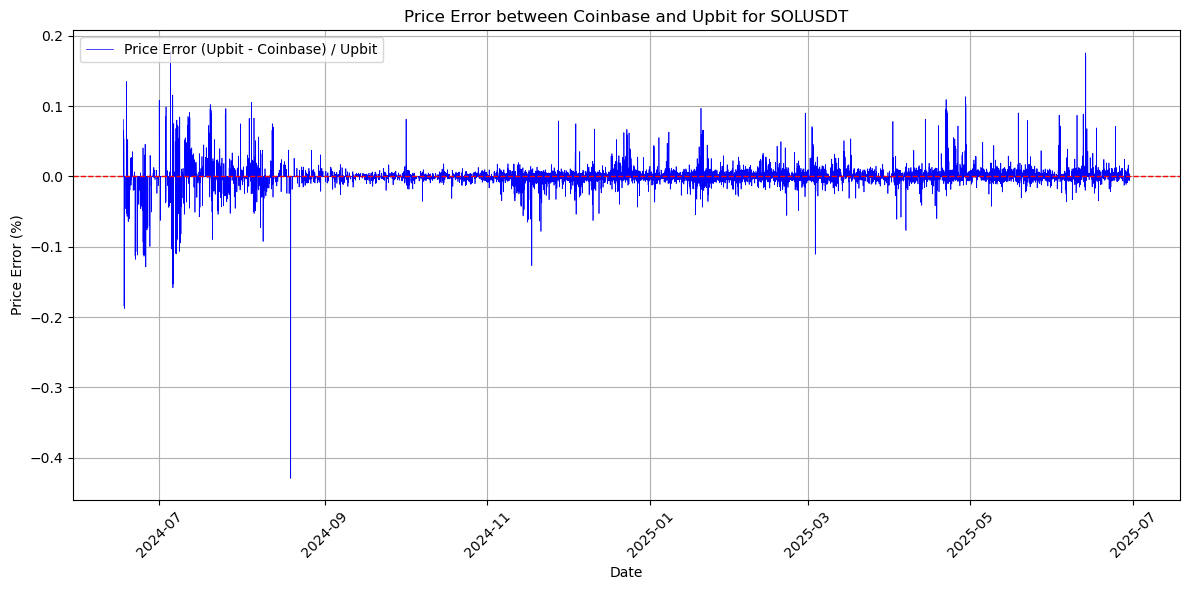

Visualizing SOLUSDT - upbit vs binanceus


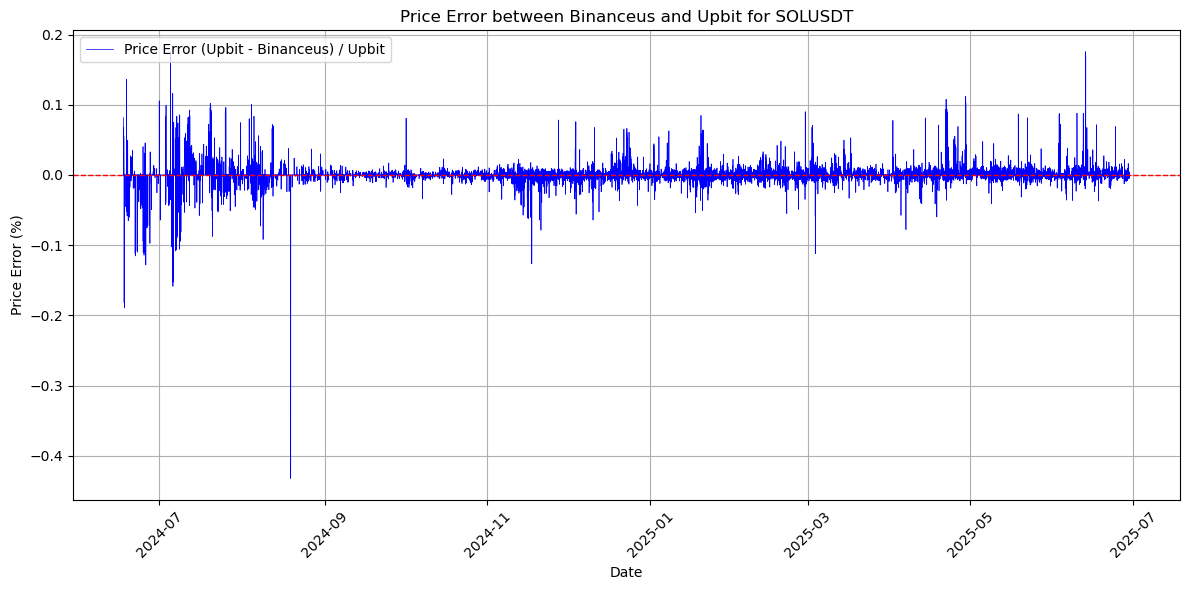

In [17]:

import matplotlib.pyplot as plt
import os


for f in os.listdir('./kimchi-premium'):
    if not f.endswith('.csv'):
        continue
    token, kor_exc, global_exc = f.split('_')[:3]
    print(f"Visualizing {token} - {kor_exc} vs {global_exc}")

    df_merged = pd.read_csv(os.path.join('./kimchi-premium', f))
    df_merged['time'] = pd.to_datetime(df_merged['time'], utc=True)
    kor_exc, global_exc = f.split('_')[1:3]
   

    # 시각화
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 주 y축: price error 선 그래프
    ax1.plot(df_merged['time'], df_merged['price_error'],
            label=f'Price Error ({kor_exc.capitalize()} - {global_exc.capitalize()}) / {kor_exc.capitalize()}',
            color='blue', linewidth=0.5)
    ax1.axhline(0, color='red', linestyle='--', linewidth=1)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price Error (%)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(loc='upper left')

# ax2 = ax1.twinx()
# ax2.step(daily_counts.index, daily_counts.values,
#          color='green', where='mid', label='Daily Count')
# ax2.set_ylabel('Data Count')
# ax2.legend(loc='upper right')

    plt.title(f'Price Error between {global_exc.capitalize()} and {kor_exc.capitalize()} for {token}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()